In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict 
import plotly
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
import re
import seaborn as sns
from sklearn.inspection import permutation_importance
from plotly.subplots import make_subplots


## Helper functions

In [2]:
def standardize(X_train, X_test):
    """Standardize the columns of X_train and X_test w.r.t. means and stds from X_train. """
    if ~(X_train.columns == X_test.columns).all():
        raise ValueError("X_train and X_test should have the columns in the same order.")
    colnames = X_train.columns
    sc = StandardScaler()
    # Standardize train and test sets (it produces numpy arrays)
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)

    # Add column names back to resulting numpy arrays
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=colnames)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=colnames)
    return X_train_scaled, X_test_scaled

## Load the datasets

In [169]:
df_hh = pd.read_stata('../../ada-2020-project-milestone-p2-stima83/Data/PisoFirme_AEJPol-20070024_household.dta')
df_ind = pd.read_stata('../../ada-2020-project-milestone-p2-stima83/Data/114542-V1/PisoFirme_AEJPol-20070024_individual.dta')

In [170]:
# We split the dataset into the census (2000) and the survey data (2005)
index_census = list(df_hh.columns[df_hh.columns.str.startswith('C')])
index_survey = list(df_hh.columns[df_hh.columns.str.startswith('S')])
df_hh = df_hh.dropna(subset = index_census + index_survey)
df_census = df_hh[index_census].copy()
df_survey = df_hh[index_survey].copy()

In [5]:
# Split into test and training set
train_split = 0.7
train_samples = np.random.rand(df_hh.shape[0]) < train_split
df_census_train = df_census.loc[train_samples]
df_census_test = df_census.loc[~train_samples]
df_survey_train = df_survey[train_samples]
df_survey_test = df_survey[~train_samples]

## Predict different survey targets
We predict the different survey values from the census data from 2000. We create a data array of the results for the different models. We calculate and report the $R^2$ scores for the different targets of the survey data and the different models.
We use the different models:
- Linear models
    - Linear regression: A simple linear regression is always a good baseline to see how the more advance machine learning techniques perform compared to the linear regressor.
    - Ridge regression: The Ridge regression use a L2 regularization term that penalizes the size of the coefficients and 'shrinks' these coefficients. Therefore, the model becomes more robust to collinearity.
- Non-linear models
    - DecisionTreeRegressor: A decision tree is build from the data and can have a very high depht.
    - GradientBoostingRegressor: Builds a certain number of weak learners (decsion trees with a shallow depht) and combine these in order to have a strong prediction. 
    - MLPRegressor: The multi-layer perceptron is a fully connected neural network that is able to build complex non linear models.

In [49]:
def generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models):
    results = np.zeros((len(selected_models), len(df_survey_train.columns)))
    for i, model in enumerate(selected_models):
        for j, (column_name, column_data) in enumerate(df_survey_train.iteritems()):
            model.fit(df_census_train, column_data)
            results[i,j] = model.score(df_census_test, df_survey_test[column_name])
    string_selected_models = [re.match(r'([a-zA-Z]+)\(.+', str(model)).group(1) for model in selected_models]
    return pd.DataFrame(results, columns=df_survey_train.columns, index=string_selected_models)

def wrapper_generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models, standardize_=True):
    if standardize_:
        df_census_train, df_census_test = standardize(df_census_train, df_census_test) 
    df_results = generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models)
    return df_results

In [94]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

selected_models = [LinearRegression(),
                   Ridge(),
                   DecisionTreeRegressor(),
                   GradientBoostingRegressor(),
                   MLPRegressor(max_iter=3000, learning_rate_init=0.1, learning_rate='adaptive',hidden_layer_sizes=(50,), )]
# We use the standard parameters for all the models except for the MLP. For the MLP, we tried different values but we could
# not really find a value that was much better than another one. We use an adaptive learning rate of 0.1 and 50 hidden layers. 

We calculate the $R^2$ score with a standardized and non-standardized dataset. Different algorithms improve in performance when standardizing and others have in general no need for standardization like the Gradient Boosting Regressor. We will see how the different algorithms behave in the following.

In [95]:
# Without standardization
df_results = wrapper_generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models, standardize_=False)

In [96]:
# With standardization
df_results_standardized = wrapper_generate_prediction_df(df_census_train, df_census_test, df_survey_train, df_survey_test, selected_models, standardize_=True)

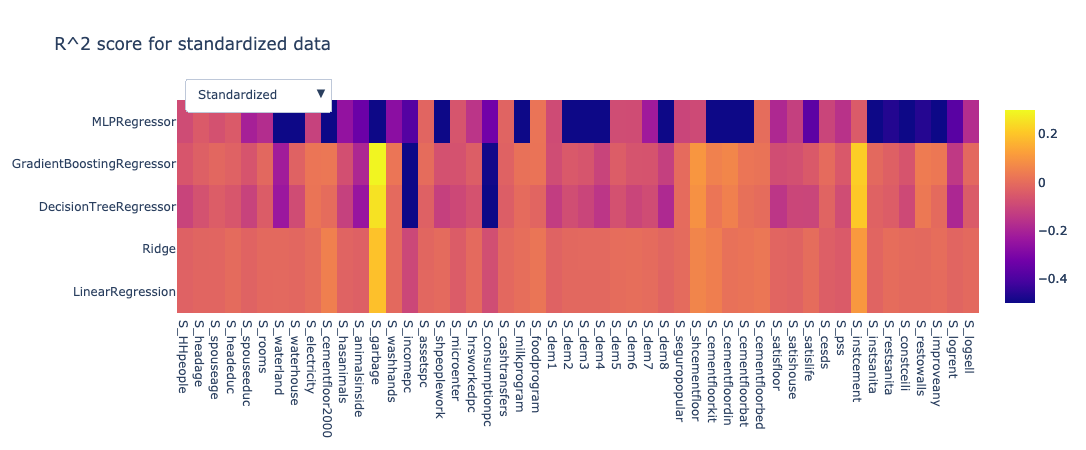

In [52]:
fig = go.Figure()

fig.add_trace(go.Heatmap(   x = df_results.columns,
                            y = df_results.index,
                            z = df_results.values,
                            name = 'Non standardized',
                            zmin= -0.5,
                            zmax = 0.3))

fig.add_trace(go.Heatmap(   x = df_results_standardized.columns,
                            y = df_results_standardized.index,
                            z = df_results_standardized.values,
                            name = 'Standardized',
                            zmin= -0.5,
                            zmax = 0.3))

fig.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    method="update",
                    args=[{"visible": [False, True]},
                           {"title": "R^2 score for standardized data"}],
                    label="Standardized"
                    
                ),
                dict(
                    method="update",
                    args=[{"visible": [True, False]},
                           {"title": "R^2 score for non-standardized data"}],
                    label="Non standardized"
                    
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.01,
            xanchor="left",
            y=1.15,
            yanchor="top"
        ),
    ]
)
fig.layout.title = "R^2 score for standardized data"
fig.write_html('../figures/taskb_R2_scores_heatmap.html')
fig.show(auto_open=False)

The heatmap that summarizes the results of our predictions from the different algorithms is very dense in information. Therefore, we need to make further analysis in the following. We clearly notice that the MLP performs quite badly in our test (even after trying to optimize the parameters.) Therfore, we will not consider this model in the follwing analysis. The cause of the bad performance might be the lack if enough datapoints. We only have 1390 datapoints for the training set. This might explain the bad performance of the MLP.

In [ ]:
df_results = df_results.drop(index=['MLPRegressor'])
df_results_standardized = df_results_standardized.drop(index=['MLPRegressor'])

#### Comparison between mean performance of the different algorithms

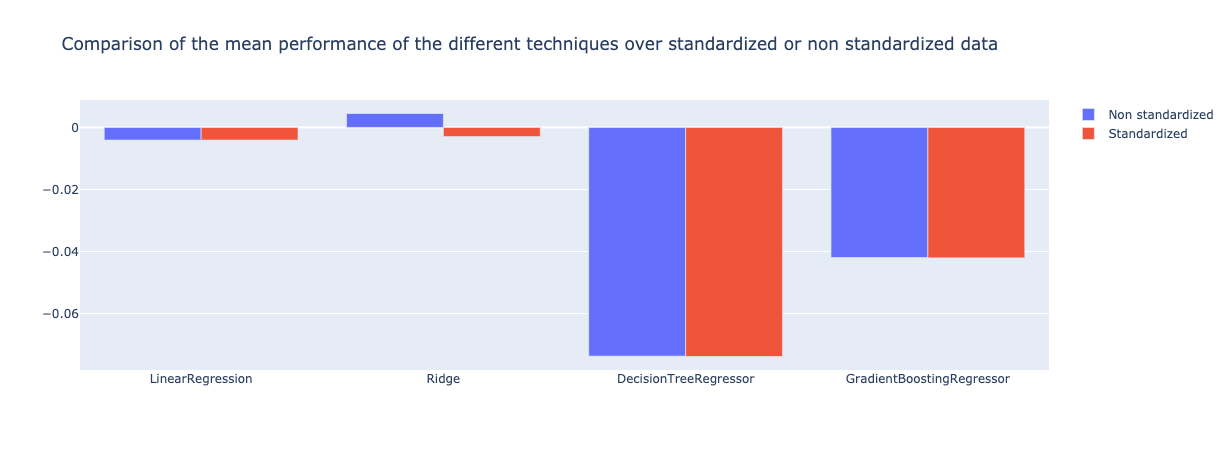

In [99]:
fig = go.Figure()
df_result_average = df_results.mean(axis=1)
df_result_stand_average = df_results_standardized.mean(axis=1)
fig.add_trace(go.Bar(x = df_result_average.index, y=df_result_average.values, name='Non standardized'))
fig.add_trace(go.Bar(x = df_result_stand_average.index, y=df_result_stand_average.values, name='Standardized'))
fig.update_layout(title=go.layout.Title(text="Comparison of the mean performance of the different \
techniques over standardized or non standardized data"))
fig.show()
fig.write_html('../figures/taskb_mean_r2_performance_all_predictions.html')

When we compare the results  between the different average performances of our five regressors, we notice that the overall performance of all the regressors are not very good. The Linear and Ridge Regressor seem to have the best performance than the non-linear regressor. This is mostly explained by the fact that they don't have a very bad performance on variables that are difficult to predict. The non-linear techniques perform far better than the non-linear ones on some variables, where a good prediction seems  to be feasible. We will in the following analysis focus on the variables for which we can make a meaningful prediction and compare the different models for these. 

In [100]:
chosen_variables = df_results.mean(axis=0).sort_values(ascending=False)[:5]
chosen_variables

S_garbage           0.232318
S_instcement        0.158125
S_shcementfloor     0.077114
S_cementfloorkit    0.042787
S_cementfloordin    0.036036
dtype: float64

In [101]:
chosen_variables = list(chosen_variables.index)

We computed the mean $R^2$ score for all the variables over all the models and choose the five variables for which we can potentially make a meaningful prediction. 

Let's graph the R^2 score for the different models in a barplot again.

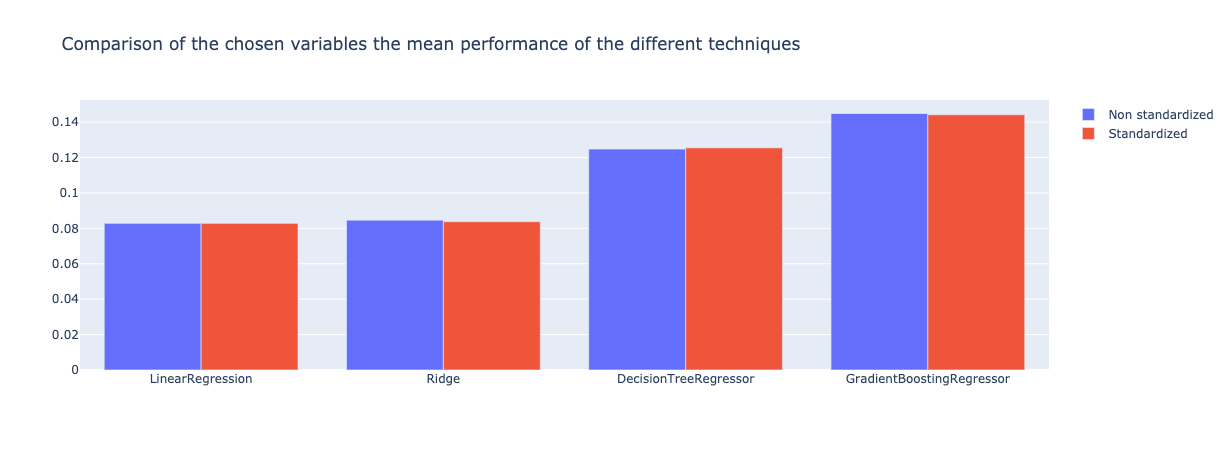

In [102]:
# chosen_variables = chosen_variables
df_results_chosen = df_results[chosen_variables]
df_results_standardized_chosen = df_results_standardized[chosen_variables]
fig = go.Figure()
df_result_average_chosen = df_results_chosen.mean(axis=1)
df_result_stand_average_chosen = df_results_standardized_chosen.mean(axis=1)
fig.add_trace(go.Bar(x = df_result_average_chosen.index, y=df_result_average_chosen.values, name='Non standardized'))
fig.add_trace(go.Bar(x = df_result_stand_average_chosen.index, y=df_result_stand_average_chosen.values, name='Standardized'))
fig.update_layout(title=go.layout.Title(text="Comparison of the chosen variables the mean performance of the different techniques"))
fig.show()
fig.write_html('../figures/mean_r2_performance_chosen_predictions.html')

This plot offers a very different picture on the performance of the different regressors. The Linear and the Ridge regression perform very similarly. The non-linear methods perform better than the linear techniques. The gradient boosting method is able to deliver the best results. For the Gradient Boosting, the standardization does not improve the score and we will just use the non standardized data in the following.

## Analysis for the selected variables
In the following, we will focus on the selected variables and analyse if we can predict them from the census data from 2000. We will use the Gradient Bosting Regressor as its overall performance was the best. We will also analyse what features are the most important in the prediction of the variable. We will plot the feature importances for the different predictions. We still need to be careful with high cardinality features of the impurity-based feature importance scores (high cardinality tends to have a higher feature importance score). Moreover, the impurity-based feature importance score will not be meaningful if we have correlated features. One correlated feature might have a very high score while the other one is very small. Therefore, we use the permutation feature score on test data to reanalyse the feature importances. The idea of the permutation feature score is to test the influence of a feature immediatly on the model. For unimportant features, the have little effects on the predictive power of the model and the permutation of important feature should have a big negative influence on the predictive power. (Source: We have used some explainations from https://blog.datadive.net/selecting-good-features-part-iii-random-forests/, https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

### Functions

In [138]:
def plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, model, survey_targets):
    fig = make_subplots(rows=2, cols=1)
    for target in survey_targets:
        model.fit(df_census_train, df_survey_train[target])
        feature_importances = model.feature_importances_
        df_feature_importances = pd.DataFrame(feature_importances, index=df_census_train.columns, columns=['Feature importance']).sort_values('Feature importance', ascending=False)
        fig.add_trace(go.Bar(x = df_feature_importances.index, y=df_feature_importances['Feature importance']), row=1, col=1)
        results = permutation_importance(model, df_census_test, df_survey_test[target], n_repeats=100, random_state=42, n_jobs=2)['importances']
        df_results = pd.DataFrame(results.T, columns=df_census.columns)
        df_results = df_results[df_feature_importances.index]
        fig2 = px.box(pd.melt(df_results), x='variable', y='value')
        fig.add_trace(fig2.data[0], row=2, col=1)
    fig.update_layout(title=go.layout.Title(text=f"Impurity based feature importance and permutation importance for {survey_targets[0]}"))
    fig.update_layout(showlegend=False)
    fig.write_html(f'../figures/taskb_feature_importance_{survey_targets[0]}.html')
    fig.show()
    
    
from sklearn.ensemble import GradientBoostingClassifier
def plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, model, survey_targets):
    fig = go.Figure()
    for target in survey_targets:
        model.fit(df_census_train, df_survey_train[target])
        prediction = model.predict(df_census_test)
        fpr, tpr, thresholds = roc_curve(df_survey_test[target], prediction)
        auc_metric = roc_auc_score(df_survey_test[target], prediction)
    print(f'The Area Under ROC curve is {auc_metric}')
    label_dict = {'x':'False positive rate', 'y':'True positive rate'}
    fig = px.line(x=fpr, y=tpr, width=600, height=600, title=f'ROC curve for {target}', labels=label_dict)
    fig.update_layout(showlegend=False)
    fig.write_html(f'../figures/taskb_AUC_curve_{survey_targets[0]}.html')
    fig.show()

### S_garbage
#### Def: This is a binary variable that tells us if this households have access to garbage collection service.

In [103]:
df_hh['S_garbage'].value_counts()

1.0    1617
0.0     336
Name: S_garbage, dtype: int64

This is a binary value, which tells us if we use garbage collection. In this case, we can use a classification algorithm and see how easily we can predict this value. Most of the households dispose of garbage collection, therefore we should not use the naive accuracy score to judge the quality of our prediction. The naive prediction of saying that we predict that all the households have garbage collection leads to an accuracy score of $\frac{1617}{1617+336}\ =\ 0.830$. This score would give the impression that our predictions is good even if it does not provide is any additional information. In order to better judge the quality of the predictor, we will plot the Receiver Operating Characteristic (ROC) curve and provide the Area Under Plot (AUC) score. The ROC curve is able to illustrate the quality of a predictor by ploting the False positive rate ($\text{FP rate} = \frac{\text{FP}}{\text{FP}+\text{TN}}$, $\text{TP rate} = \frac{\text{TP}}{\text{FP}+\text{FN}}$) against the True positive rate for different threshold levels. The AUC score summarizes this plot in a meaningful way by calculating the area under this curve. The closer it is to 1, the better the prediction is. A score of 0.5 means, that the performance of the regressor is randomly guessing.

The Area Under ROC curve is 0.8465780460904393


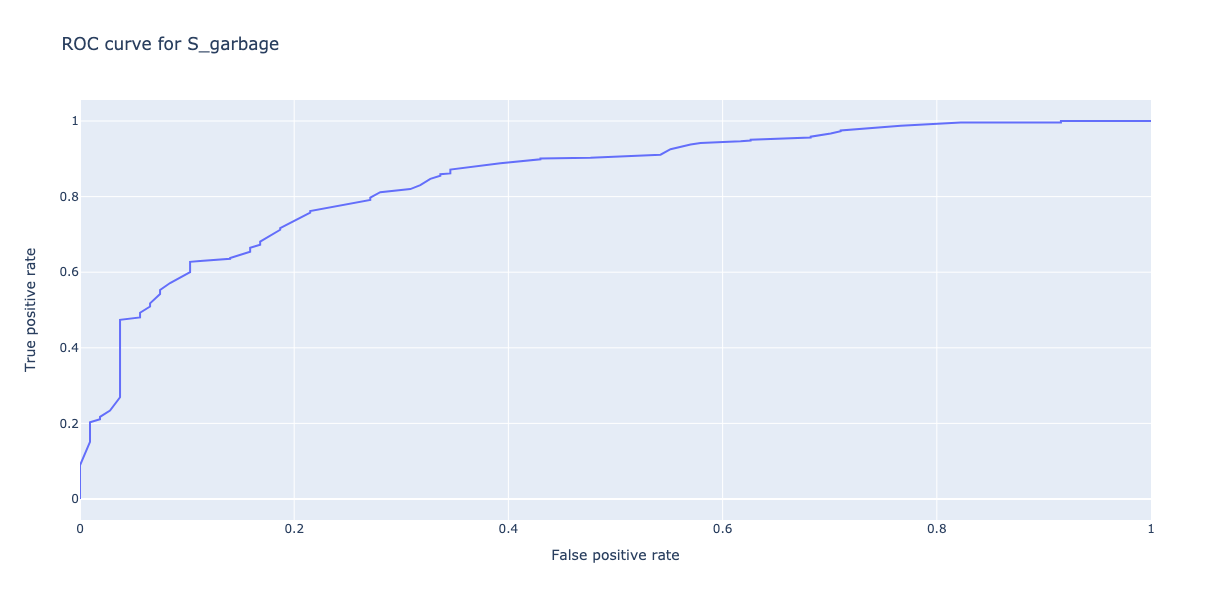

In [113]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_garbage'])

Our model performs in a decent way on this variable and can often predict what households will get garbage collection from the census data. In the following, we will analyse how important the different features were in the prediction.

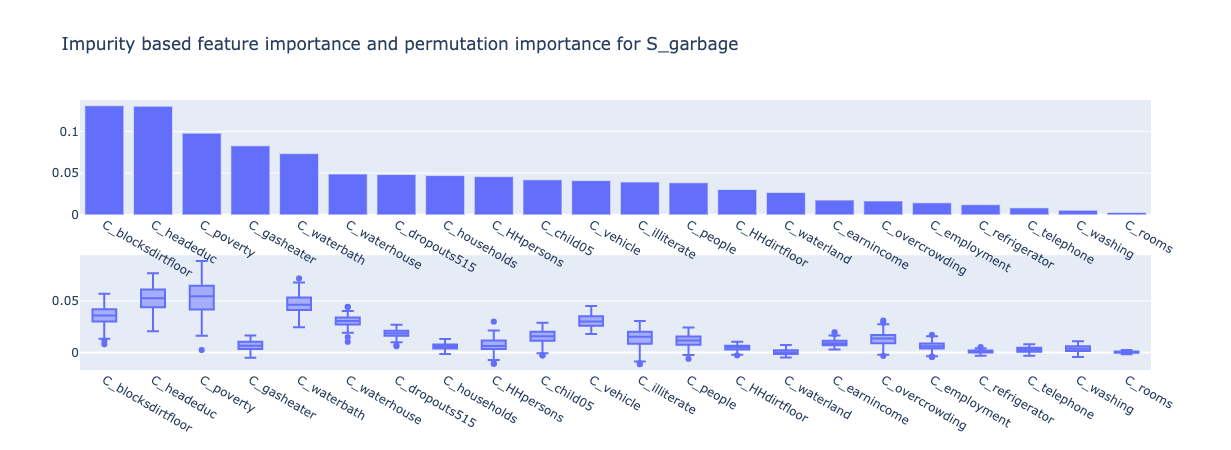

In [139]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_garbage'])

Both plots we produce give a very different picture of the feature importance. Some of the features are important in both plots, but some are also overestimated in the impurity-based feature importance analysis. Examples for features that are overestimated are `C_blocksdirtfloor` and `C_gasheater`. These two variables have a high cardinality of 93 for the `C_blocksdirtfloor` and 109 for `C_gasheater`. 

Good indicators to predict if the household has garbage collection 5 years into the future are `C_poverty` and `C_headeduc`. We can only hypotheszise why these two features are the most important:
- `C_poverty`: Most of the household that are economically better of have already garbage collection in 2000. Therefore the interesting part is to predict if the poorest of the households will have garbage collection. Government programs might also focus the most on the poorest households. This makes this variable quite important. We need to notice that the confidence interval for this variable is very large.
- `C_headeduc`: The average number of schooling years of an household might be predictive in a sense that an educated person will know about the importance of garbage collection service for the general hygiene and will also be able to articulate their needs to the institution that takes care of the garbage collection. 
We are very aware that these kind of hypothesis need to be taken with a grain of salt. The predictions are not very good and tree learners have a tendency of overfitting.

In [140]:
len(df_census_train['C_blocksdirtfloor'].unique())

93

In [141]:
len(df_census_train['C_gasheater'].unique())

109

### S_instcement
#### Def: Indicator equal to one if the household reports having installed a cement floor since 2000.

In [142]:
df_hh['S_instcement'].value_counts()

1.0    1381
0.0     572
Name: S_instcement, dtype: int64

The Area Under ROC curve is 0.7977457325283412


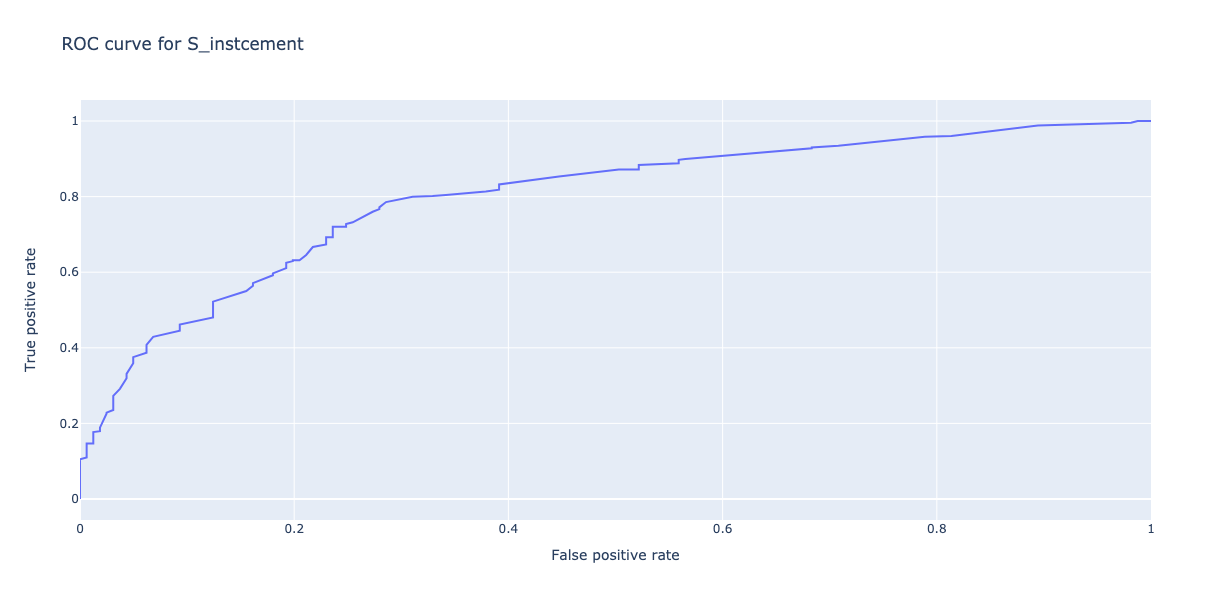

In [143]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_instcement'])

Again the predictions of our model are decent. We will turn our focus towards the feature importance of our prediction.

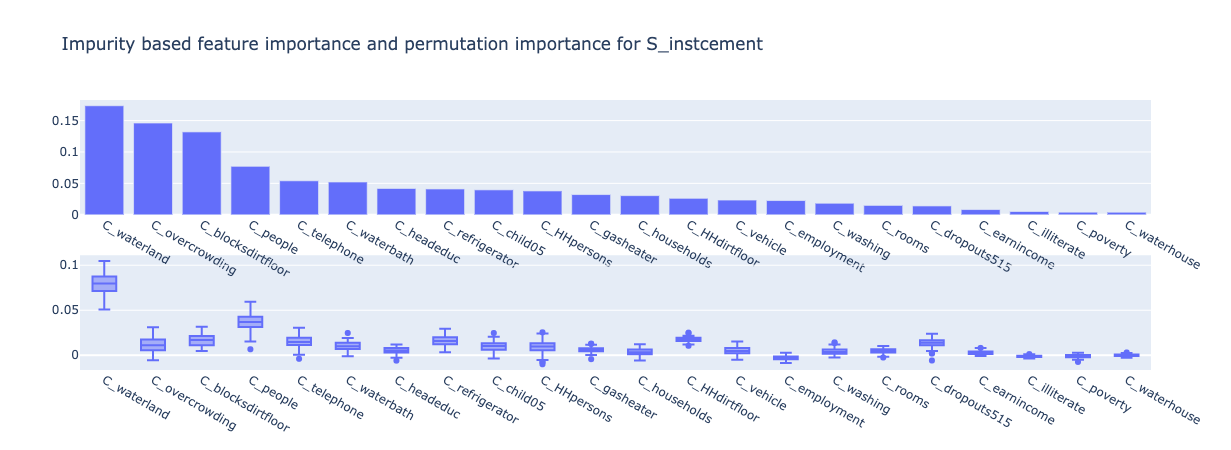

In [144]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_instcement'])

We will only consider the second subplot based on the permutation importances for our analysis. `C_waterland` and `C_people` seem to be the greatest predictor if a household will get cement floor in between 2000 and 2005. `C_waterland` is the proportion of household that has no water connection outside the house and `C_people` is the cumulated number of people. 
We can again hypothezise why these two values are the most important ones:
- We could not come up with an intuitive explaination for the importance of the `C_waterland` variable.
- If a lot of people live in a certain area, the government might turn its attention more easily towards these households. Therefore, they might have higher probabilities of profiting from such a program. 

### S_cementfloordin and S_cementfloorkit
#### Def: Cement floor in dining room and in the kitchen
We will treat both predictions in this subsection because it could be interesting to compare the results for both. 

In [145]:
df_hh['S_cementfloordin'].value_counts()

1.0    1589
0.0     364
Name: S_cementfloordin, dtype: int64

The Area Under ROC curve is 0.7227214252300014


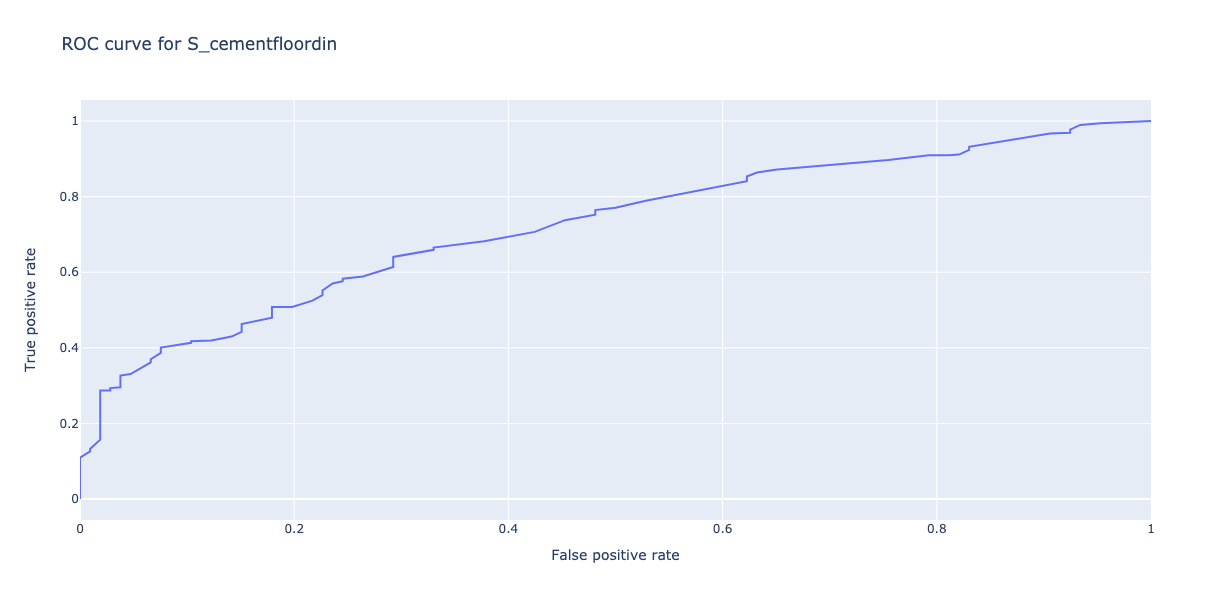

In [154]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloordin'])

The Area Under ROC curve is 0.7104254948627156


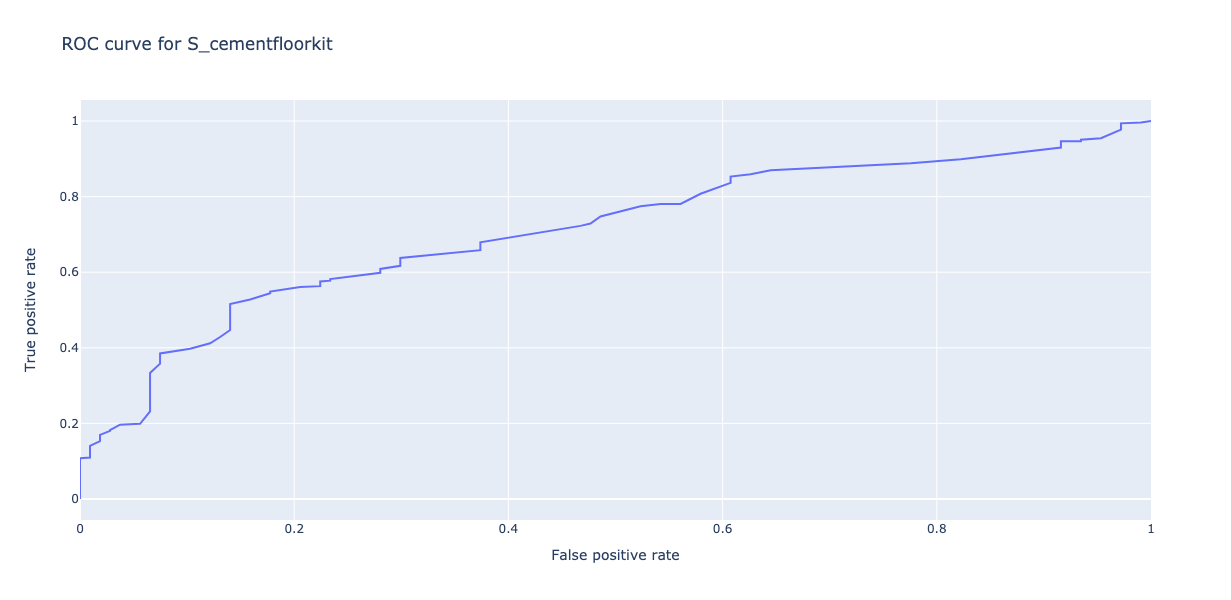

In [155]:
plot_AUC_curve(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloorkit'])

Both predictions are acceptable and there quality is quite similar.

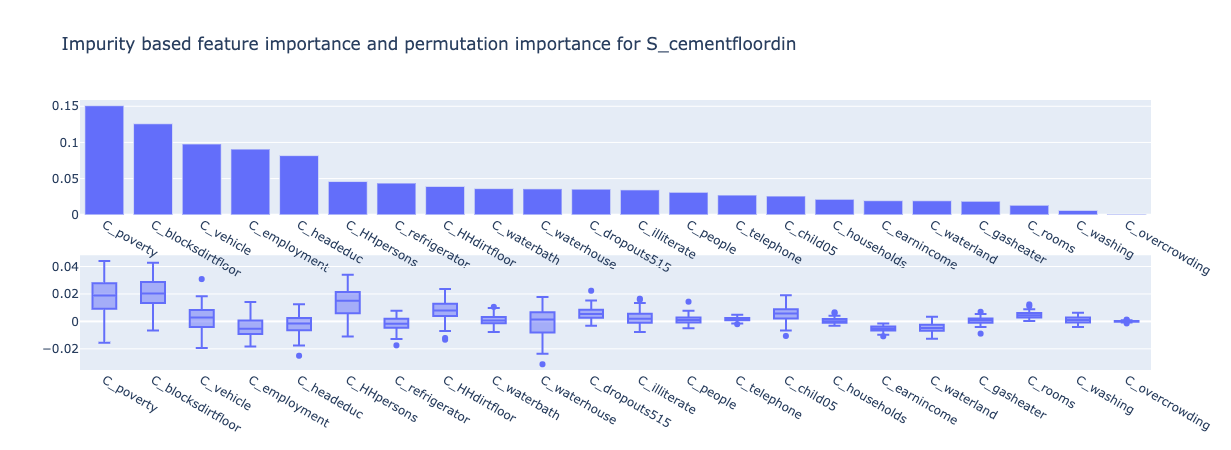

In [147]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloordin'])

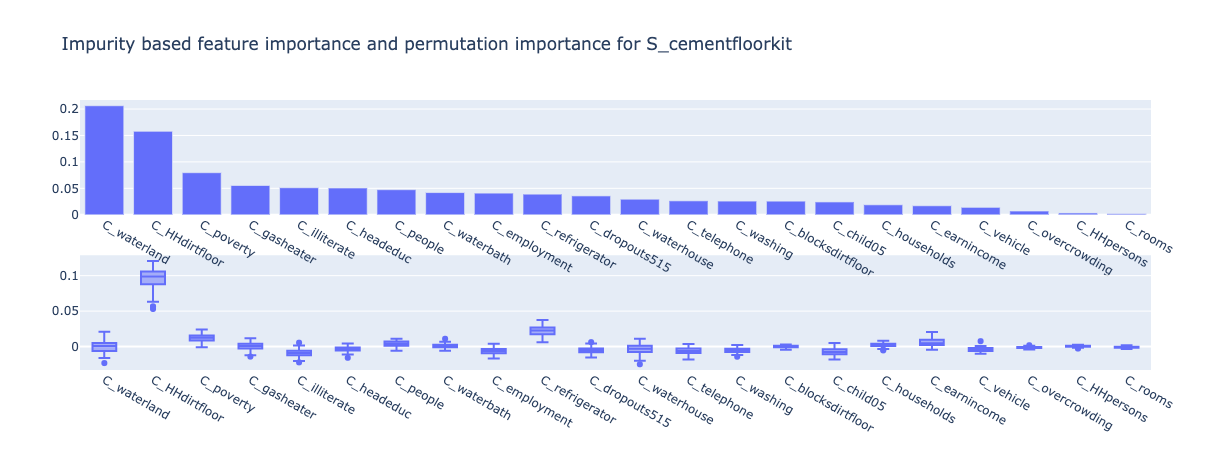

In [153]:
plot_feature_importance(df_survey_train, df_survey_test, df_census_train, df_census_test, GradientBoostingRegressor(), ['S_cementfloorkit'])

In [185]:
(df_hh['S_cementfloorkit'].astype(int).astype(str) + df_hh['S_cementfloordin'].astype(int).astype(str)).value_counts()

11    1481
00     293
01     108
10      71
dtype: int64

The incidence of people having a cement floor in the dinning room before having a cement floor in the kitchen is slighly bigger as we can see. 108 households that don't have a cement floor in the kitchen, have a cement floor in the dining room compared to 71 households where it is the other way around.

`S_cementfloordin` does not really have features that are much more important than other when we consider the permutation importance scores. So an analysis is rather difficult. For `S_cementfloorkit`, we have `C_HHdirtfloor` and a little less important `C_refrigerator`. We hypothezise:
-`C_HHdirtfloor`: We don't really know why this feature would be more important particularly to predict the presence of cement floor in the kitchen. By the little analysis just above, we could show that often the kitchen is one of the last rooms that gets a concrete floor. Therefore, the information what proportion of dirtfloors are in the households might be particularly important.
-`C_refrigerator`: This value seems to influence the prediction also in a meaningful way. this might make sense, because the presence of a refrigerator might indicate if a kitchen is often used and how the hygienic standards are in this particular household. If the kitchen is often used and standards are high, the investment in a concrete floor is more probable.

### S_shcementfloor
Def: Share of rooms with cement floors

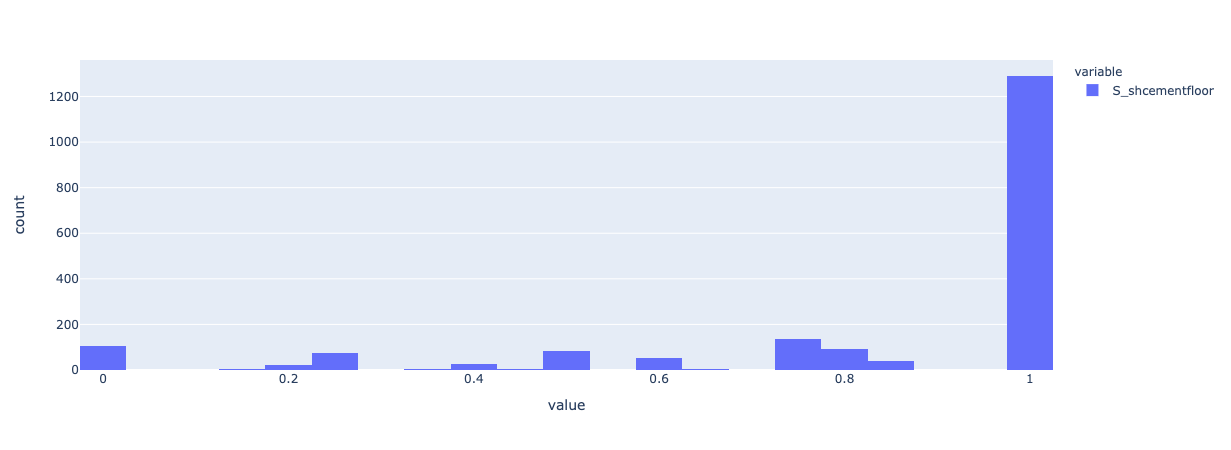

In [148]:
import plotly.figure_factory as ff
px.histogram(df_hh['S_shcementfloor'], ['S_shcementfloor'])

Most of the households have already 100% concrete floors. The other households have different shares of concrete floors. 106 households live in particularly difficult circumstances without any concrete floors in their home. 

In [189]:
model = GradientBoostingRegressor()
model.fit(df_census_train, df_survey_train['S_shcementfloor'])
result = model.score(df_census_test, df_survey_test['S_shcementfloor'])
result

0.10252212344660794

The results are not very good. From census data it seems to be difficult to infer the proportion of concrete floors 5 years later.

## Overall conclusions
We see that in general the census data from 2000 does not allow us to construct a good model to predict the different features of the survey in 2005. This is not astonishing as the census data has less granularity than the survey data that is specific to every household. The cenus data mostly reports averages over an area that is composed of many households. There are still a few values, where some algorithms are able to make decent predictions. 